# **Time Series Generator**

This script will make you able to generate a chosen number of time series of random stocks at random period of time.


In [1]:
import numpy as np
import numpy.random as rd
import pandas as pd

rd.seed(42)

For Colab, it downloads the data using the following code. 

If you work locally be sure to have the folder *data/*. You can download it from the repo.

In [2]:
try:
  from google.colab import files
  !wget -q https://github.com/Amelrich/Capstone-Fall-2020/archive/master.zip
  !unzip -q master.zip
  !mv Capstone-Fall-2020-master/data/ data/
  !rm -rf master.zip Capstone-Fall-2020-master/
except:
  print("only in Colab")

## The generator

It generates random timeseries picked from random stocks at random times.

Currently you can access to the generated time series using the method `get_list_of_df` (see example below). Next improvements will allow to choose a wider range of structures like arrays etc.



In [3]:
class TS_generator:
  def __init__(self, nb_timeseries=2000, chunk_size=100):
    
    self.chunk_size = chunk_size
    self.nb_timeseries = nb_timeseries

    #Retrieve the stocks names
    self.symbols = pd.read_csv('https://raw.githubusercontent.com/Amelrich/Capstone-Fall-2020/master/sp500.csv', index_col=False)
    self.symbols = list(self.symbols['Symbol'].values)
    self.symbols = ['BF-B' if x=='BF.B' else x for x in self.symbols]
    self.symbols = ['BRK-B' if x=='BRK.B' else x for x in self.symbols]

    self.list_df = []

    #Build the random time series
    self.build_()

  def build_(self):

    TS_list = []
    indexes = [] #Starting date indexes
    total_len = 0

    for stock in self.symbols:
      TS = pd.read_csv('data/'+stock+'.csv')
      TS_list.append(TS)
      indexes += list(range(total_len, total_len + len(TS) - self.chunk_size))
      total_len += len(TS)

    TS = pd.concat(TS_list, ignore_index=True)
    del(TS_list)

    #Pick random starting dates
    random_starts = rd.choice(indexes, self.nb_timeseries)

    for start in random_starts:
      self.list_df.append( TS[start : start+self.chunk_size] )

    del(TS)

  def get_list_of_df(self):
    #
    return self.list_df

  def get_array(self):
    #Return adjusted close array
    close_array = np.zeros((self.nb_timeseries, self.chunk_size))

    for i in range(self.nb_timeseries):
      close_array[i,:] = self.list_df[i]['Adj Close'].to_numpy()

    return close_array

# Example

In [4]:
gen = TS_generator(nb_timeseries=3000, chunk_size=60)
X = gen.get_array()
X.shape

(3000, 60)

In [5]:
class MedianScaler:
  def __init__(self,):
    self.median = None
    self.mad = None

  def fit(self, X):
    self.median = np.median(X, axis=0)
    self.mad = np.median( np.abs(X - self.median), axis=0 )

  def fit_transform(self, X):
    self.median = np.median(X, axis=0)
    self.mad = np.median( np.abs(X - self.median), axis=0 )
    return (X - self.median) / self.mad

  def transform(self, X):
    return (X - self.median) / self.mad

In [6]:
#Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Xs = StandardScaler().fit_transform(X.T).T
Xmm = MinMaxScaler().fit_transform(X.T).T
Xmed = MedianScaler().fit_transform(X.T).T
Xp = ((X.T - X[:,0]) / X[:,0]).T
Xmed.shape

(3000, 60)

# **Autoencoders**

In [7]:
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import Model, Input
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, InputLayer
import keras.regularizers as reg
from keras.optimizers import Adam

In [8]:
class Autoencoder:
    def __init__(self, time_step, n_features=1):
        self.encoder = Sequential()
        self.encoder.add(Dense(20, input_shape=(time_step,)))
                               #kernel_regularizer=reg.l1(0.001),
                               #bias_regularizer=reg.l1(0.001),
                               #activity_regularizer=reg.l1(0.01)) )
        #self.encoder.add(LSTM(10, input_shape=(time_step, n_features), return_sequences=True))
        #self.encoder.add(LSTM(20))

        self.decoder = Sequential()
        self.decoder.add(Dense(40, activation='tanh'))
        self.decoder.add(Dense(time_step))

        self.autoencoder = Model( self.encoder.input, self.decoder(self.encoder.output) )
        self.encoding_model = Model( self.encoder.input, self.encoder.output )

        opt = Adam(learning_rate=0.001)
        self.autoencoder.compile(optimizer=opt, loss='mse')
        print(self.autoencoder.summary())
        #print(self.encoding_model.summary())

    def fit(self, X_train, X_test, epochs=50, verbose=1):
        self.autoencoder.fit(X_train, X_train, batch_size=16, epochs=epochs, shuffle=True,
                             verbose=verbose, validation_data=(X_test, X_test))

    def encode(self, x):
        return self.encoding_model.predict(x)

    def predict(self, x):
        return self.autoencoder.predict(x)


In [9]:
model = Autoencoder(time_step=60)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_input (InputLayer)     [(None, 60)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                1220      
_________________________________________________________________
sequential_1 (Sequential)    (None, 60)                3300      
Total params: 4,520
Trainable params: 4,520
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
X_train, X_val = Xs[:2000,:], Xs[2000:,:]

In [11]:
model.fit(X_train, X_val, epochs=150, verbose=1)

Epoch 1/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4901 - val_loss: 0.2629
Epoch 2/150
125/125 [==============================] - 0s 2ms/step - loss: 0.2175 - val_loss: 0.1792
Epoch 3/150
125/125 [==============================] - 0s 2ms/step - loss: 0.1607 - val_loss: 0.1402
Epoch 4/150
125/125 [==============================] - 0s 2ms/step - loss: 0.1314 - val_loss: 0.1196
Epoch 5/150
125/125 [==============================] - 0s 1ms/step - loss: 0.1142 - val_loss: 0.1057
Epoch 6/150
125/125 [==============================] - 0s 2ms/step - loss: 0.1023 - val_loss: 0.0955
Epoch 7/150
125/125 [==============================] - 0s 1ms/step - loss: 0.0931 - val_loss: 0.0877
Epoch 8/150
125/125 [==============================] - 0s 1ms/step - loss: 0.0859 - val_loss: 0.0815
Epoch 9/150
125/125 [==============================] - 0s 2ms/step - loss: 0.0803 - val_loss: 0.0765
Epoch 10/150
125/125 [==============================] - 0s 2ms/step - loss: 0.0759 - val_lo

No handles with labels found to put in legend.


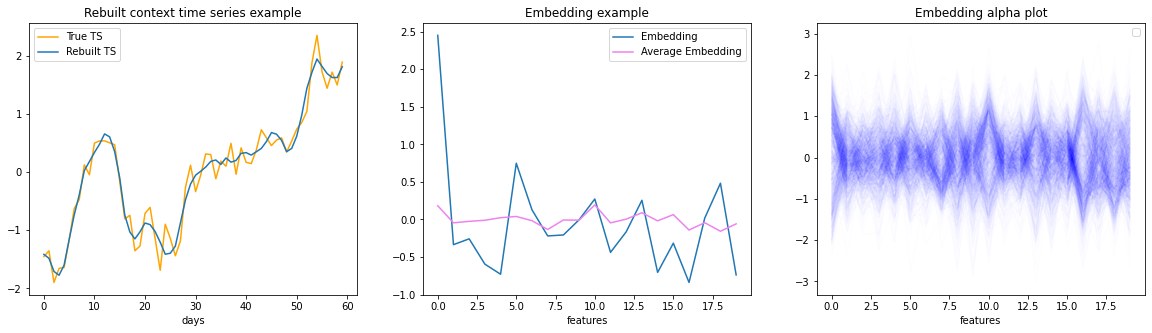

In [12]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

idx = 0
x_emb = model.encode(X_val[idx,:].reshape(1,60))[0]
x_rebuilt = model.predict(X_val[idx,:].reshape(1,60))[0]
mean_emb = model.encode(X_val).mean(axis=0)

ax[0].plot(X_val[idx,:], c='orange', label='True TS')
ax[0].plot(x_rebuilt, label='Rebuilt TS')
ax[0].set_xlabel('days')
ax[0].set_title('Rebuilt context time series example')
ax[0].legend()

ax[1].plot(x_emb, label='Embedding')
ax[1].plot(mean_emb, c='violet', label='Average Embedding')
ax[1].set_xlabel('features')
ax[1].set_title('Embedding example')
ax[1].legend()

x_emb = model.encode(X_val)
for i in range(len(X_val)):
    ax[2].plot(x_emb[i,:], alpha=0.0075, c='blue')

ax[2].set_xlabel('features')
ax[2].set_title('Embedding alpha plot')
ax[2].legend()

plt.show()

# Clustering

In [13]:
try:
  from tslearn.clustering import TimeSeriesKMeans
except:
  !pip -q install tslearn
  from tslearn.clustering import TimeSeriesKMeans

     |████████████████████████████████| 778kB 2.8MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [14]:
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
from collections import Counter

In [15]:
embedding = model.encode(X_train).T
#embedding = (embedding * X[:2000].std(axis=1)) + X[:2000].mean(axis=1)
embedding = MinMaxScaler().fit_transform(embedding).T
#embedding = model.encode(X_train)
embedding.shape

(2000, 20)

In [16]:
X_cluster = np.concatenate([Xmm[:2000][:,40:], embedding], axis=1)
X_cluster.shape

(2000, 40)

In [17]:
cl = KMeans(n_clusters=10)
y_train_pred = cl.fit_predict(X_cluster)

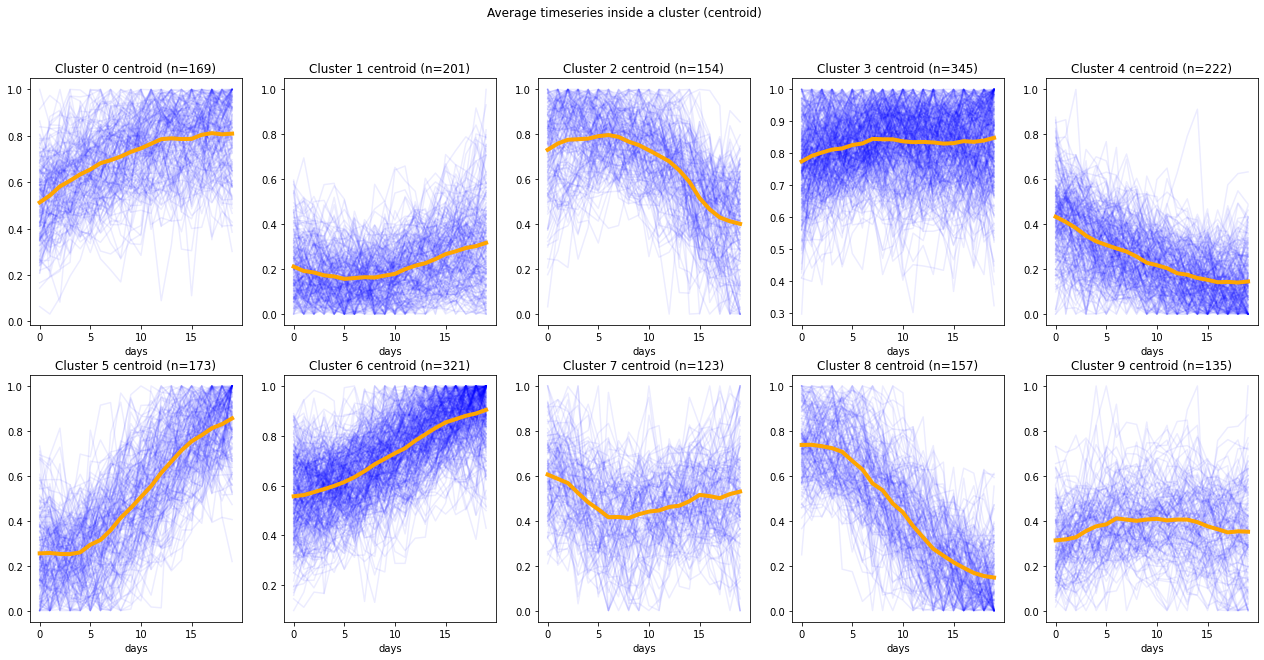

In [18]:
fig, ax = plt.subplots(2, 5, figsize=(22,10))
fig.suptitle('Average timeseries inside a cluster (centroid)')

for k in range(5):
  indices = [i for i,x in enumerate(y_train_pred) if x == k]
  X_mean = X_cluster[indices,:20].mean(axis=0)
  for idx in indices:
    ax[0,k].plot(X_cluster[idx,:20], alpha=0.075, c='blue')
  ax[0,k].plot(X_mean, c='orange', linewidth=4)
  ax[0,k].set_xlabel('days')
  ax[0,k].set_title(f'Cluster {k} centroid (n={len(indices)})')

  indices = [i for i,x in enumerate(y_train_pred) if x == k+5]
  X_mean = X_cluster[indices,:20].mean(axis=0)
  for idx in indices:
    ax[1,k].plot(X_cluster[idx,:20], alpha=0.075, c='blue')
  ax[1,k].plot(X_mean, c='orange', linewidth=4)
  ax[1,k].set_xlabel('days')
  ax[1,k].set_title(f'Cluster {k+5} centroid (n={len(indices)})')


plt.show()

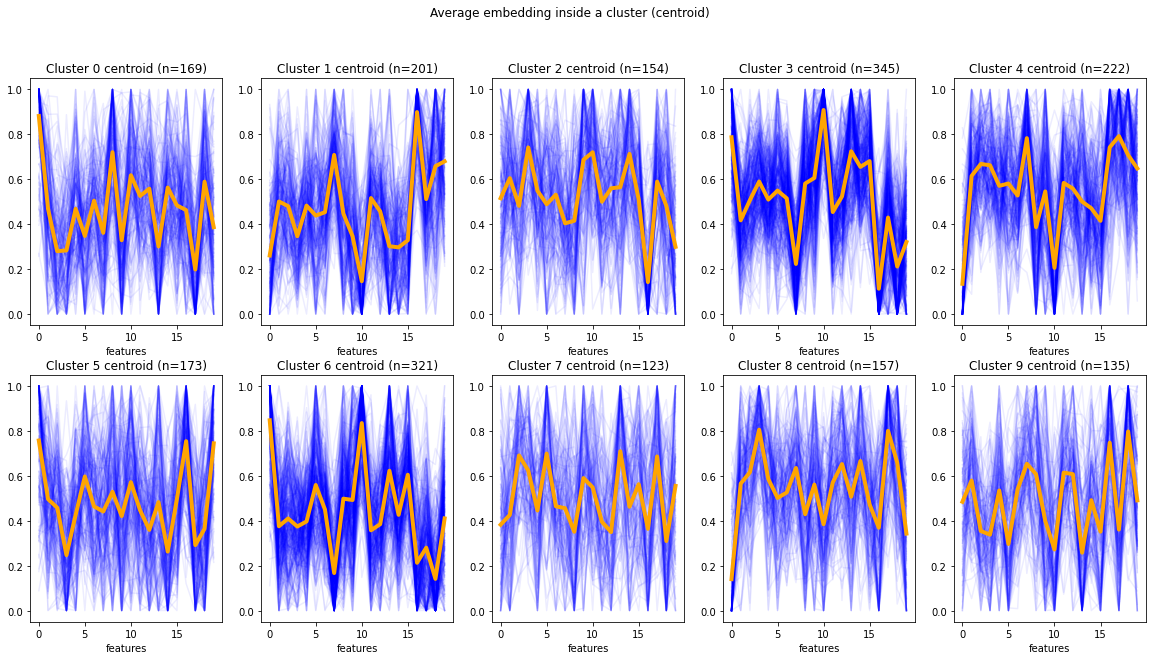

In [19]:
fig, ax = plt.subplots(2, 5, figsize=(20,10))
fig.suptitle('Average embedding inside a cluster (centroid)')

for k in range(5):
  indices = [i for i,x in enumerate(y_train_pred) if x == k]
  X_mean = X_cluster[indices,20:].mean(axis=0)
  for idx in indices:
    ax[0,k].plot(X_cluster[idx,20:], alpha=0.075, c='blue')
  ax[0,k].plot(X_mean, c='orange', linewidth=4)
  ax[0,k].set_xlabel('features')
  ax[0,k].set_title(f'Cluster {k} centroid (n={len(indices)})')

  indices = [i for i,x in enumerate(y_train_pred) if x == k+5]
  X_mean = X_cluster[indices,20:].mean(axis=0)
  for idx in indices:
    ax[1,k].plot(X_cluster[idx,20:], alpha=0.075, c='blue')
  ax[1,k].plot(X_mean, c='orange', linewidth=4)
  ax[1,k].set_xlabel('features')
  ax[1,k].set_title(f'Cluster {k+5} centroid (n={len(indices)})')


plt.show()

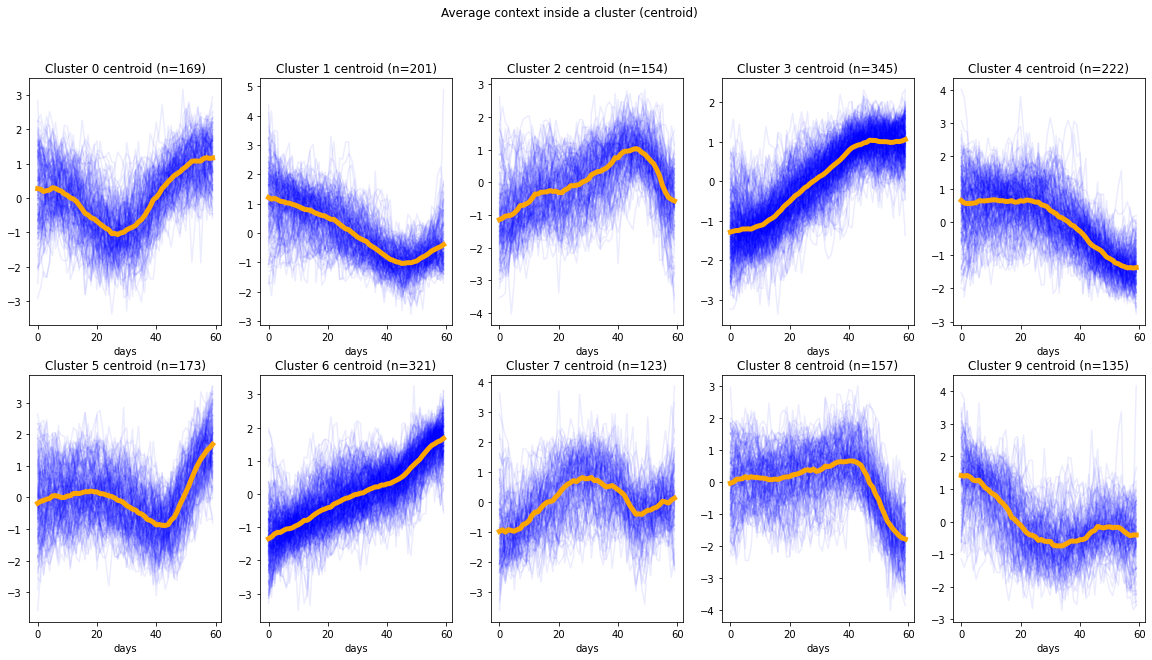

In [20]:
fig, ax = plt.subplots(2, 5, figsize=(20,10))
fig.suptitle('Average context inside a cluster (centroid)')

for k in range(5):
  indices = [i for i,x in enumerate(y_train_pred) if x == k]
  X_mean = X_train[indices,:].mean(axis=0)
  for idx in indices:
    ax[0,k].plot(X_train[idx,:], alpha=0.075, c='blue')
  ax[0,k].plot(X_mean, c='orange', linewidth=5)
  ax[0,k].set_xlabel('days')
  ax[0,k].set_title(f'Cluster {k} centroid (n={len(indices)})')

  indices = [i for i,x in enumerate(y_train_pred) if x == k+5]
  X_mean = X_train[indices,:].mean(axis=0)
  for idx in indices:
    ax[1,k].plot(X_train[idx,:], alpha=0.075, c='blue')
  ax[1,k].plot(X_mean, c='orange', linewidth=5)
  ax[1,k].set_xlabel('days')
  ax[1,k].set_title(f'Cluster {k+5} centroid (n={len(indices)})')


plt.show()

## Silhouette score

In [21]:
from sklearn.metrics import silhouette_samples

def sil_sample_cluster(data, col1, col2, thresh):
  '''
  computes the percentage of silhouette scores about a threshold within each cluster
  (input) data: DataFrame; col1: str refering to cluster column; col2: str refering to silhouette scores column; thresh: float between -1 and 1
  (output) ss_scores; dictionary
  '''
  ss_scores = {}
  for i in range(data[col1].nunique()):
    subs = data[data[col1]==i]
    ss_thresh = subs[subs[col2]>=thresh]
    ss_scores[i] = len(ss_thresh)/len(subs)
  
  return ss_scores

In [22]:
from sklearn.metrics import silhouette_samples

silhouette_scores = silhouette_samples(X_cluster, y_train_pred)

clusters_ss = pd.concat([pd.DataFrame(y_train_pred, columns= ['cluster']), pd.DataFrame(silhouette_scores, columns = ['silhouette_score'])], axis = 1)
clusters_ss.head() 

sil_sample_cluster(clusters_ss, 'cluster', 'silhouette_score', 0.3) #0 for all

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.034782608695652174,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0}

In [23]:
from sklearn.metrics import silhouette_score

silhouette_score(X_cluster, y_train_pred)

0.0961322738003376

In [35]:
score = []
silhouette = []
max_cluster=25

for k in range(2,max_cluster):
  cl = KMeans(n_clusters=k)
  y_train_pred = cl.fit_predict(X_cluster)
  silhouette.append( silhouette_score(X_cluster, y_train_pred) )
  score.append(cl.inertia_)

Text(0.5, 1.0, 'Silhouette score')

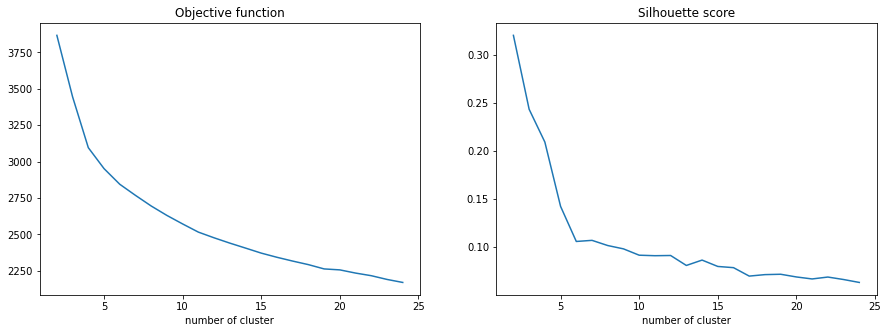

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(list(range(2,max_cluster)), score)
ax[0].set_xlabel('number of cluster')
ax[0].set_title(f'Objective function')

ax[1].plot(list(range(2,max_cluster)), silhouette)
ax[1].set_xlabel('number of cluster')
ax[1].set_title(f'Silhouette score')

In [37]:
def elbow(score_tab):
  a = (score_tab[-1] - score_tab[0]) / len(score_tab)
  b = score_tab[0]

  elb_tab = [ np.abs(score_tab[i] - a*i - b) / np.sqrt(a*a + 1) for i in range(len(score_tab)) ]
  return elb_tab.index(max(elb_tab))

In [38]:
print("Best k for Kmeans with objective function:", elbow(score)+2)
print("Best k for Kmeans with silhouette score:", elbow(silhouette)+2)

Best k for Kmeans with objective function: 7
Best k for Kmeans with silhouette score: 6


In [46]:
cl = KMeans(n_clusters=4)
y_train_pred = cl.fit_predict(X_cluster)
silhouette_score(X_cluster, y_train_pred)

0.2091261644580078

In [47]:
from sklearn.metrics import silhouette_samples

silhouette_scores = silhouette_samples(X_cluster, y_train_pred)

clusters_ss = pd.concat([pd.DataFrame(y_train_pred, columns= ['cluster']), pd.DataFrame(silhouette_scores, columns = ['silhouette_score'])], axis = 1)
clusters_ss.head() 

sil_sample_cluster(clusters_ss, 'cluster', 'silhouette_score', 0.3) #0 for all

{0: 0.017391304347826087,
 1: 0.46064516129032257,
 2: 0.0,
 3: 0.38049713193116635}

## Other visualizations

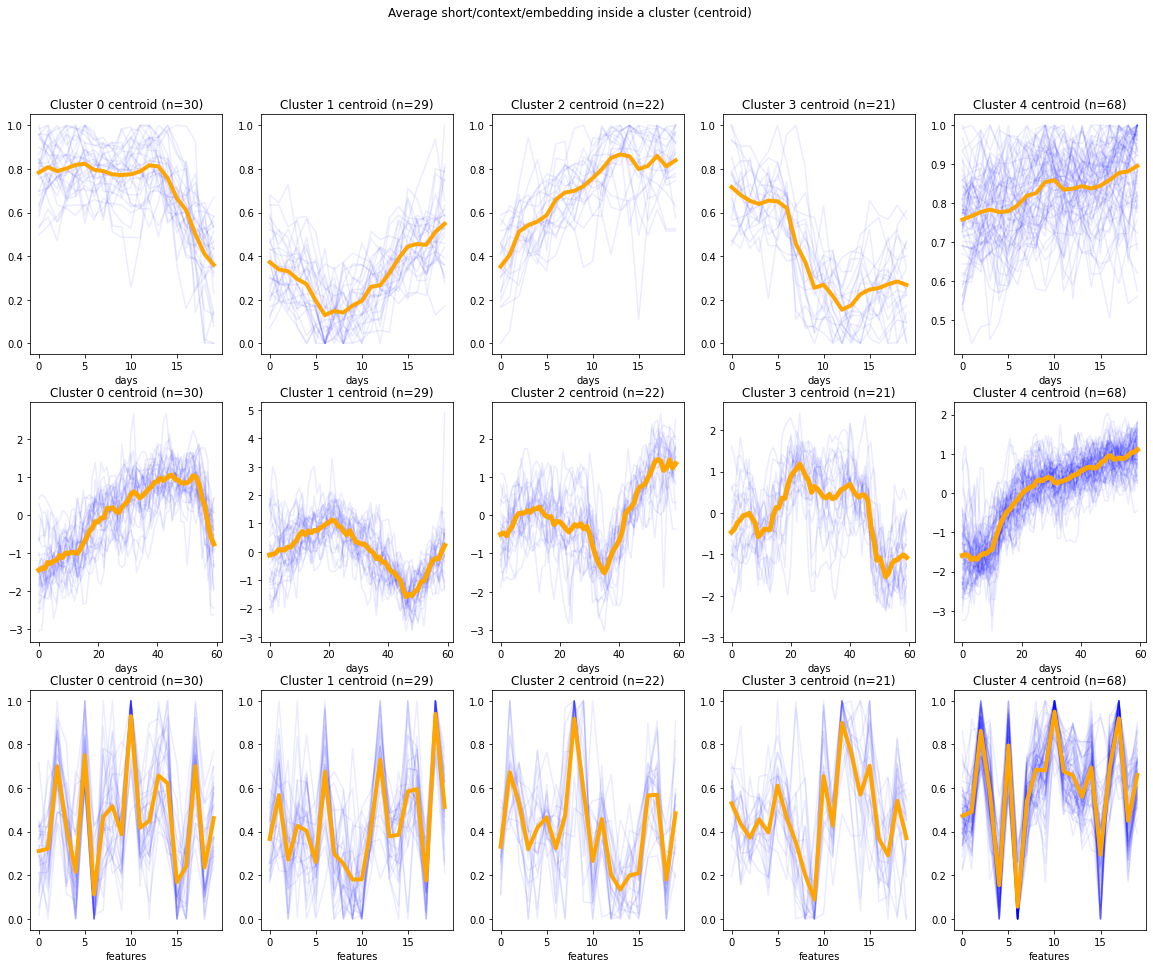

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(20,15))
fig.suptitle('Average short/context/embedding inside a cluster (centroid)')

for k in range(5):

  indices = [i for i,x in enumerate(y_train_pred) if x == k]
  X_mean = X_cluster[indices,:20].mean(axis=0)
  for idx in indices:
    ax[0,k].plot(X_cluster[idx,:20], alpha=0.075, c='blue')
  ax[0,k].plot(X_mean, c='orange', linewidth=4)
  ax[0,k].set_xlabel('days')
  ax[0,k].set_title(f'Cluster {k} centroid (n={len(indices)})')


  X_mean = X_train[indices,:].mean(axis=0)
  for idx in indices:
    ax[1,k].plot(X_train[idx,:], alpha=0.075, c='blue')
  ax[1,k].plot(X_mean, c='orange', linewidth=5)
  ax[1,k].set_xlabel('days')
  ax[1,k].set_title(f'Cluster {k} centroid (n={len(indices)})')


  X_mean = X_cluster[indices,20:].mean(axis=0)
  for idx in indices:
    ax[2,k].plot(X_cluster[idx,20:], alpha=0.075, c='blue')
  ax[2,k].plot(X_mean, c='orange', linewidth=4)
  ax[2,k].set_xlabel('features')
  ax[2,k].set_title(f'Cluster {k} centroid (n={len(indices)})')




plt.show()

In [ ]:
class T_Linear(keras.layers.Layer):
    def __init__(self, units=32):
        super(T_Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        ind = np.triu_indices(n=input_shape[-1], m=self.units, k=1)
        self.w[tf.constant(ind[0])].trainable = False

        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b